Etsy Handmade Shops – Exploratory Data Analysis (EDA)
This notebook performs exploratory data analysis (EDA) on a cleaned dataset of Etsy handmade shops.
The main goals are to:
- explore where mostly shops are located,
- understand how shop attributes (age, number of listings, engagement) relate to sales,
- compare shops with and without marketing messages,
- prepare the data for simple predictive modelling of sales.

In [1]:
# BASIC DATA HANDLING
import pandas as pd
import numpy as np

# VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# MACHINE LEARNING (optional – for simple regression)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Settings for nicer plots
sns.set(style="whitegrid")


Load cleaned dataset and basic overview of structure and basic statistics

In [4]:
df = pd.read_csv('../data/etsy_shops_data_cleaned.csv')
print("Dataset shape:", df.shape)
display(df.head())
print("\nDataset info:")
df.info()
print("\nStatistical summary:")
display(df.describe())


Dataset shape: (6313, 9)


,creation_date,listing_active_count,num_favorers,currency_code,sale_message,sales_count,review_count,shop_location,country
0,19-Nov,3,1,USD,False,0,0,"Kansas City, Missouri",United States
1,19-Nov,40,1,USD,False,0,0,"Kharkiv, Ukraine",Ukraine
2,19-Nov,7,1,USD,False,0,0,"New York, United States",United States
3,19-Nov,12,2,USD,False,0,0,"Tel Aviv, Israel",Israel
4,19-Nov,12,6,USD,True,1,0,"Pittsburgh, Pennsylvania",United States



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6313 entries, 0 to 6312
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   creation_date         6313 non-null   object
 1   listing_active_count  6313 non-null   int64 
 2   num_favorers          6313 non-null   int64 
 3   currency_code         6313 non-null   object
 4   sale_message          6313 non-null   bool  
 5   sales_count           6313 non-null   int64 
 6   review_count          6313 non-null   int64 
 7   shop_location         6313 non-null   object
 8   country               6313 non-null   object
dtypes: bool(1), int64(4), object(4)
memory usage: 400.9+ KB

Statistical summary:


,listing_active_count,num_favorers,sales_count,review_count
count,6313.000000,6313.000000,6313.000000,6313.000000
mean,10.677966,1.521147,2.866149,0.143038
std,32.348287,4.781198,27.823907,1.035479
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000,0.000000
75%,11.000000,2.000000,1.000000,0.000000
max,1749.000000,223.000000,1508.000000,58.000000


Distributions of key numerical variables 
Here I explore the distributions of the main numerical variables:
- `sales_count` – total number of sales
- `listing_active_count` – number of active listings
- `num_favorers` – number of users who have favourited the shop
- `review_count` – number of reviews

This helps identify skewness, outliers and the general scale of each variable.


Descriptive statistics for sales_count:
count    6313.000000
mean        2.866149
std        27.823907
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max      1508.000000
Name: sales_count, dtype: float64

Descriptive statistics for listing_active_count:
count    6313.000000
mean       10.677966
std        32.348287
min         0.000000
25%         2.000000
50%         5.000000
75%        11.000000
max      1749.000000
Name: listing_active_count, dtype: float64

Descriptive statistics for num_favorers:
count    6313.000000
mean        1.521147
std         4.781198
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max       223.000000
Name: num_favorers, dtype: float64

Descriptive statistics for review_count:
count    6313.000000
mean        0.143038
std         1.035479
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        58.000000
Name: review_count, dtype: float64


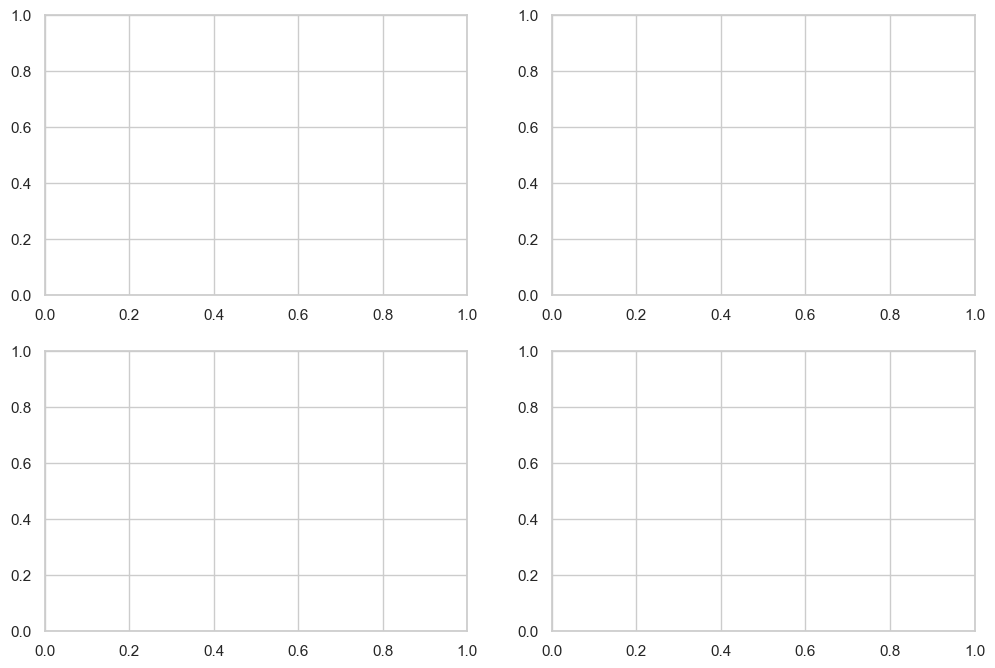

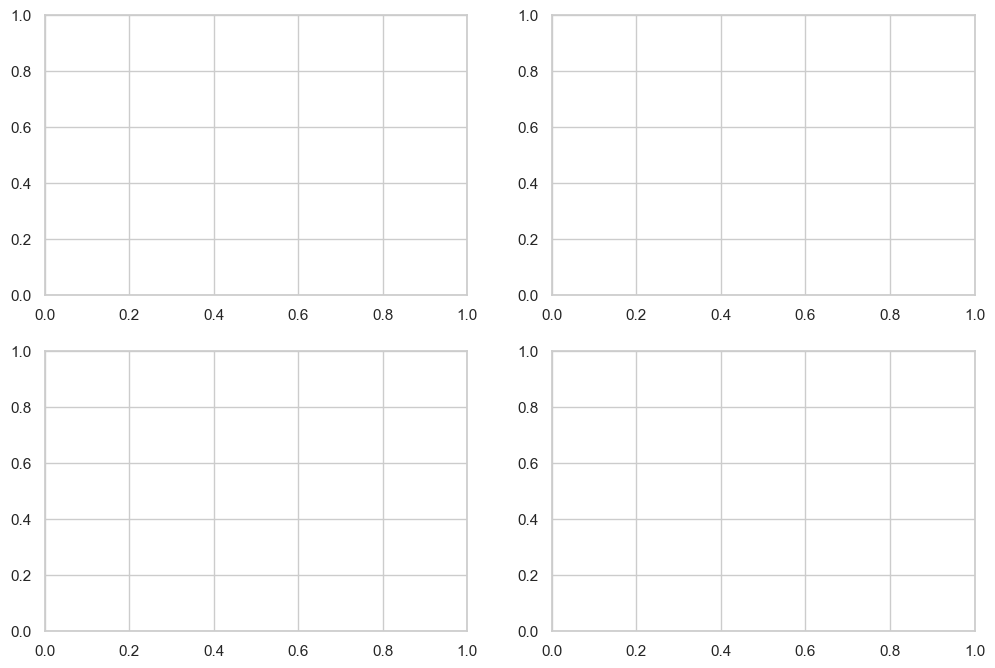

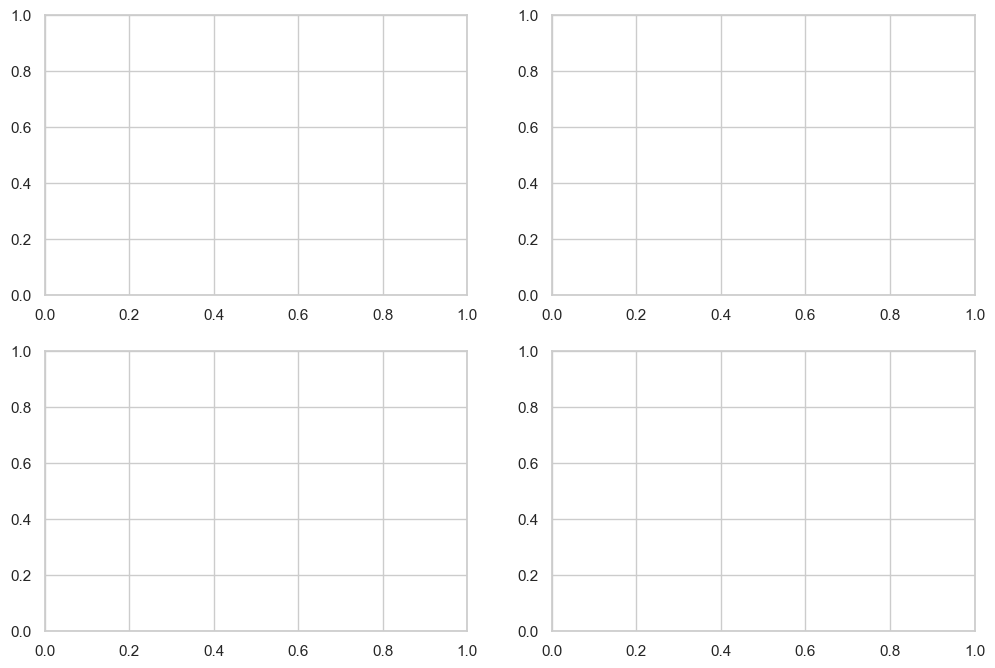

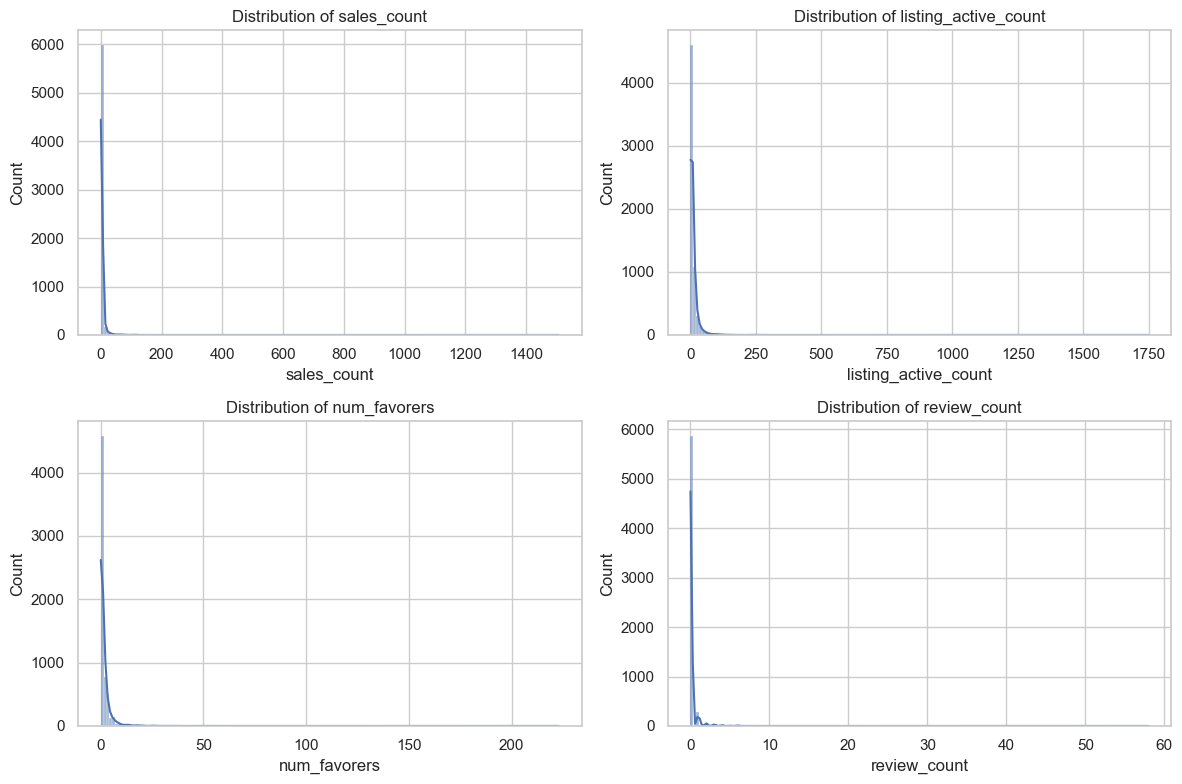

In [9]:
# find the numerical columns
numerical_cols = ['sales_count', 'listing_active_count', 'num_favorers', 'review_count']
# print descriptive statistics  for numerical columns and create histograms
for col in numerical_cols:
    print(f"\nDescriptive statistics for {col}:")
    print(df[col].describe())
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, col in zip(axes, numerical_cols):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()  

Number of shops by country

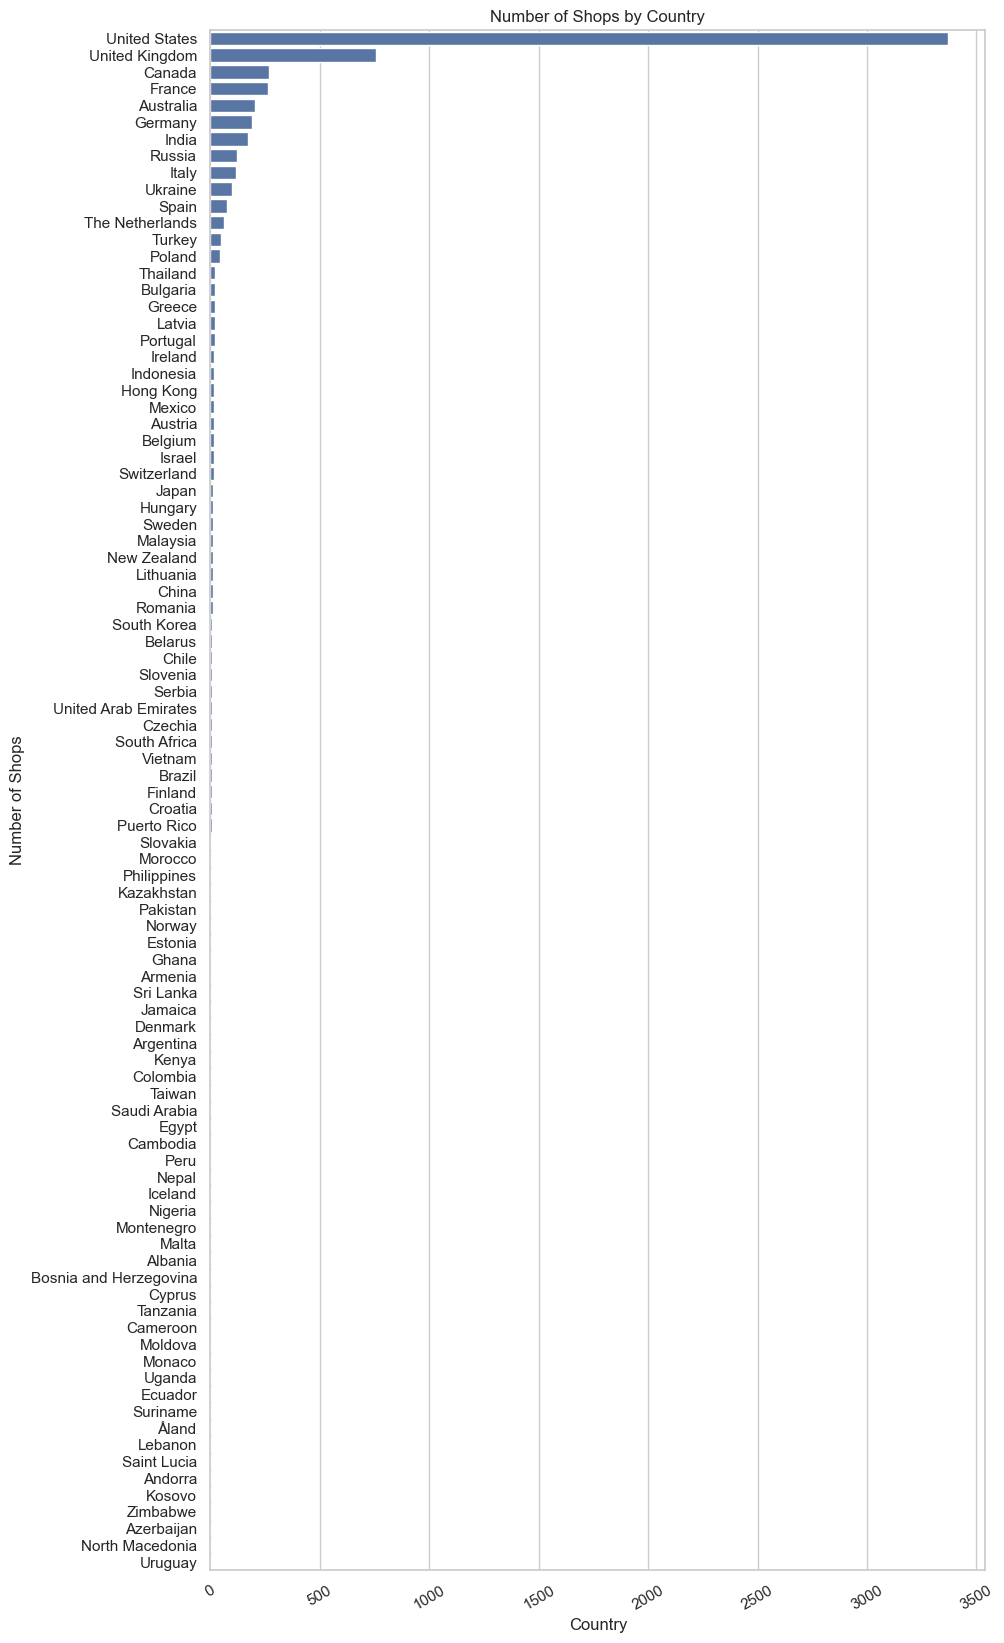

country
United States      3372
United Kingdom      758
Canada              267
France              263
Australia           205
                   ... 
Kosovo                1
Zimbabwe              1
Azerbaijan            1
North Macedonia       1
Uruguay               1
Name: count, Length: 92, dtype: int64

In [14]:
#count nummer of shops by country
plt.figure(figsize=(10, 20))
country_counts = df['country'].value_counts()
sns.barplot(x=country_counts.values, y=country_counts.index)
plt.title("Number of Shops by Country")
plt.xlabel("Country")
plt.ylabel("Number of Shops")
plt.xticks(rotation=30)
plt.show()

country_counts

H1: Shop performance varies by geographic region 
Hypothesis: Find out which location may influence higher sales, due to larger customer markets. 
Figure 1: Number of shops by world region (bar chart) 
Figure 2: Sales distribution per region (boxplot)

H2: Sales increase with shop age and number of active listings 
Hypothesis: Older shops with more active products generate more sales. 
Figure 3: Sales Count vs Shop Age (scatterplot) 
Figure 4: Sales Count vs Number of Listings (scatterplot with trendline)

H3: Shops with marketing enabled (“sale_message = TRUE”) perform better 
Hypothesis: Shops using marketing or promotion messages achieve higher sales and more reviews. 
Figure 5: Sales by Marketing Status (boxplot) 
Figure 6: Reviews vs Marketing Status (bar chart)

H4: Customer engagement (favourers, reviews) is correlated with sales Hypothesis: Shops that receive more favourites and reviews have higher sale counts. Figure 7: Correlation heatmap (num_favorers, review_count, sales_count)

Simple regression model to predict sales, a linear regression model with:
- target variable: `sales_count`
- predictors: `listing_active_count`, `num_favorers`, `review_count`, and (if available) `shop_age_years`.

This is not a production-ready model, but it provides a first approximation  
of how these features combine to explain variation in sales.

In [ ]:
Summary of EDA findings